In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import toml
import timeit
import pandas as pd
import math

In [4]:
param = toml.load("config.toml")
path = param.get("path")
minFeatures = param.get("minFeatures")
camera_path = param.get("camera_path")
encoder_path = param.get("encoder_path")
calib = param.get("calib")
NP = param.get("NP")
MAX_RANGE = param.get("MAX_RANGE")

In [5]:
class Visual_Odometry:
    def __init__(self,calib_mat,minFeatures):
        self.k = calib_mat
        self.minFeatures = minFeatures 
        self.r = np.zeros([3,3])
        self.t = np.zeros([3,1])
        self.pose = np.eye(4)
        self.x_loc=[]
        self.z_loc=[]
        
        self.kp1 = []
        self.kp2 = []
        self.landmarks= []
        self.matches = None
        
    def process_features(self,first_frame,second_frame,calib_matrix):
        
        self.landmarks = []
        #create sift detector object
        sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=10)
        
        # Extract sfit features from current and next frame
        keypoints_1, descriptors_1 = sift.detectAndCompute(first_frame,None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(second_frame,None)
        
        # Filter those keypoints that are matched across frames only
        keypoints_1, keypoints_2 = self.filter_features(descriptors_1, descriptors_2, keypoints_1, keypoints_2)
        
        # Compute Essential matrix from feature list
        E, mask = cv2.findEssentialMat(keypoints_1, keypoints_2, self.k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        
        # Compute rotation and translation matrices
        _, self.r, self.t, mask = cv2.recoverPose(E, keypoints_2, keypoints_1, self.k)
        
        calib_inv = np.linalg.inv(calib_matrix)
        R = np.column_stack((self.r, self.t))
        r_inv = np.linalg.pinv(R)
        
        for i in range(10):
            pose = np.hstack((keypoints_1[i], [1.0]))
            pose = np.reshape(pose,(3,1))
            ld = calib_inv @ pose
            ld = r_inv @ ld
            #ld = ld * (1/ld[3])
            self.landmarks.append([ld[0],ld[2]])
            
            
        
        return self.landmarks, self.r, self.t
    
    def filter_features(self,descriptors_1, descriptors_2, keypoints_1, keypoints_2):
        
        #Create brute force matcher object 
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

        self.matches = bf.match(descriptors_1, descriptors_2)
        
        #sort matches based on distance.
        #Lower distance between descripors -> better the match
        self.matches = sorted(self.matches, key = lambda x:x.distance)

        pts1 = []
        pts2 = []
        
        idx =  self.matches[0:self.minFeatures]

        # Gtaher kepyoint objects of filtered matches from respective frames
        for i in idx:
            pts1.append(keypoints_1[i.queryIdx].pt)
            pts2.append(keypoints_2[i.trainIdx].pt)
            self.kp1.append(keypoints_1[i.queryIdx])
            self.kp2.append(keypoints_2[i.trainIdx])

        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

        return pts1, pts2
    
    def pose_calc(self,r,t):
        
        #Combine rotation and translation matrices
        new_pose = np.column_stack((r, t))
        new_pose = np.vstack((new_pose, np.array([0,0,0,1])))
        
        self.pose = self.pose @ new_pose
        
        # Extract x and z coordinate
        self.x_loc.append(self.pose[0, -1])
        self.z_loc.append(self.pose[2, -1])
        
    def plot_trajectory(self):
        plt.figure(figsize=(6, 6), dpi=100)
        plt.title('VO Trajectory')
        plt.ylabel('Z')
        plt.xlabel('X')
        plt.gca().invert_xaxis()
        plt.plot(self.x_loc, self.z_loc)
        plt.show()

In [6]:
def calc_input(v_in,w_in):
    v = v_in  # [m/s]
    yaw_rate = w_in  # [rad/s]
    u = np.array([[v, yaw_rate]]).T
    return u


def observation(x_true, xd, u, rf_id, dt):
    x_true = motion_model(x_true, u, dt)

   
    z = np.zeros((0, 3))

    for i in range(len(rf_id[:, 0])):

        dx = x_true[0, 0] - rf_id[i, 0]
        dy = x_true[1, 0] - rf_id[i, 1]
        d = math.hypot(dx, dy) # Get observed distance from particle to landmark
        if d <= MAX_RANGE:
            #dn = d + np.random.randn() * Q_sim[0, 0] ** 0.5  # add noise
            dn = d
            zi = np.array([[dn, rf_id[i, 0], rf_id[i, 1]]])
            z = np.vstack((z, zi))

    # add noise to input
    #ud1 = u[0, 0] + np.random.randn() * R_sim[0, 0] ** 0.5
    ud1 = u[0, 0]
    #ud2 = u[1, 0] + np.random.randn() * R_sim[1, 1] ** 0.5
    ud2 = u[1, 0]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud, dt)

    return z, xd, ud


def motion_model(x, u, dt):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[dt * math.cos(x[2, 0]), 0],
                  [dt * math.sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])

    x = F.dot(x) + B.dot(u)

    return x


def gauss_likelihood(x, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma ** 2) * \
        math.exp(-x ** 2 / (2 * sigma ** 2))

    return p


def calc_covariance(x_est, px, pw):
    """
    calculate covariance matrix
    """
    cov = np.zeros((3, 3))
    n_particle = px.shape[1]
    for i in range(n_particle):
        dx = (px[:, i:i + 1] - x_est)[0:3]
        cov += pw[0, i] * dx @ dx.T
    cov *= 1.0 / (1.0 - pw @ pw.T)

    return cov


def pf_localization(px, pw, z, u, dt):
    """
    Localization with Particle filter
    """

    for ip in range(NP):
        x = np.array([px[:, ip]]).T
        w = pw[0, ip]

        #  Predict with random input sampling
        #ud1 = u[0, 0] + np.random.randn() * R[0, 0] ** 0.5
        ud1 = u[0, 0]
        #ud2 = u[1, 0] + np.random.randn() * R[1, 1] ** 0.5
        ud2 = u[1, 0]
        ud = np.array([[ud1, ud2]]).T
        x = motion_model(x, ud, dt)

        #  Calc Importance Weight
        for i in range(len(z[:, 0])):
            dx = x[0, 0] - z[i, 1]
            dy = x[1, 0] - z[i, 2]
            pre_z = math.hypot(dx, dy)
            dz = pre_z - z[i, 0]
            w = w * gauss_likelihood(dz, math.sqrt(Q[0, 0]))

        px[:, ip] = x[:, 0]
        pw[0, ip] = w

    pw = pw / pw.sum()  # normalize

    x_est = px.dot(pw.T)
    p_est = calc_covariance(x_est, px, pw)

    N_eff = 1.0 / (pw.dot(pw.T))[0, 0]  # Effective particle number
    if N_eff < NTh:
        px, pw = re_sampling(px, pw)
    return x_est, p_est, px, pw


def re_sampling(px, pw):
    """
    low variance re-sampling
    """

    w_cum = np.cumsum(pw)
    base = np.arange(0.0, 1.0, 1 / NP)
    re_sample_id = base + np.random.uniform(0, 1 / NP)
    indexes = []
    ind = 0
    for ip in range(NP):
        while re_sample_id[ip] > w_cum[ind]:
            ind += 1
        indexes.append(ind)

    px = px[:, indexes]
    pw = np.zeros((1, NP)) + 1.0 / NP  # init weight

    return px, pw

def wheel_obs(xd, u, dt):
    # add noise to input
    #ud1 = u[0, 0] + np.random.randn() * R_sim[0, 0] ** 0.5
    ud1 = u[0, 0]
    #ud2 = u[1, 0] + np.random.randn() * R_sim[1, 1] ** 0.5
    ud2 = u[1, 0]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud,dt)

    return xd, ud

def wheel_particle(px, ud, dt):
    
    for ip in range(NP):
        x = np.array([px[:, ip]]).T

        ud1 = u[0, 0]
        ud2 = u[1, 0]
        ud = np.array([[ud1, ud2]]).T
        x = motion_model(x, ud, dt)

        px[:, ip] = x[:, 0]

    return px

## Read Camera and Wheel Encoder Data

In [7]:
l=[]
vidcap = cv2.VideoCapture(camera_path)
success,image = vidcap.read()
while success:
    l.append(image)     # save frame as JPEG file      
    success,image = vidcap.read()

In [8]:
k=[]
for i in range(len(l)):
    if not(i % 2):
        k.append(l[i])
    else: 
        pass

In [9]:
tick = 87/len(k)
time_count = [i*tick for i in range(len(k))] # Time stamps of camera frames

In [10]:
df = pd.read_csv(encoder_path)
df["dt"] = df["time"].diff(1)
df=df.drop([0])

In [11]:
Q = np.diag([0.1]) ** 2  # range error
R = np.diag([1.0, np.deg2rad(40.0)]) ** 2  # input error
Q_sim = np.diag([0.1]) ** 2
R_sim = np.diag([1.0, np.deg2rad(30.0)]) ** 2
NTh = NP / 2.0

In [12]:
x_est = np.zeros((4, 1))
x_dr = np.zeros((4, 1))

px = np.zeros((4, NP))  # Particle store
pw = np.zeros((1, NP)) + 1.0 / NP

h_x_est = np.zeros((4, 1))
h_x_dr = np.zeros((4, 1))
h_px = np.zeros((4, NP))
frames = k
count = time_count

In [13]:
X = Visual_Odometry(np.asarray(calib), minFeatures)
landmarks=[]
camera = False
time = 0.0
for i in range(2,len(df)-6):
    
    dt = df["dt"][i+1]
    v = df["v"][i+1]
    w = df["w"][i+1]
    
    u = calc_input(v,w)
    
    if(time > count[1]):
        camera = True
        count = count[1:]
        
    
    if(camera):
        #print(i)
        frame1 = frames[0]
        frame2 = frames[1]
        
        landmarks, r, t = X.process_features(frame1, frame2, np.asarray(calib))
        landmarks = np.asarray(landmarks)
        
        z, x_dr, ud = observation(x_est, x_dr, u, landmarks, dt)
        x_est, PEst, px, pw = pf_localization(px, pw, z, ud, dt)
        
        h_x_est = np.hstack((h_x_est, x_est))
        h_px = np.hstack((h_px, px))
        
        frames = frames[1:]
        camera = False
        
    else:
        x_est, ud = wheel_obs(x_est, u, dt)
        px = wheel_particle(px, ud, dt)
        
        h_x_est = np.hstack((h_x_est, x_est))
        h_px = np.hstack((h_px, px))
        
        
    time += dt

## Plot Trajectory

In [15]:
x=[]
y=[]
for i in range(len(df)-6):
    x.append(h_x_est[0][i])
    y.append(h_x_est[1][i])

<IPython.core.display.Javascript object>


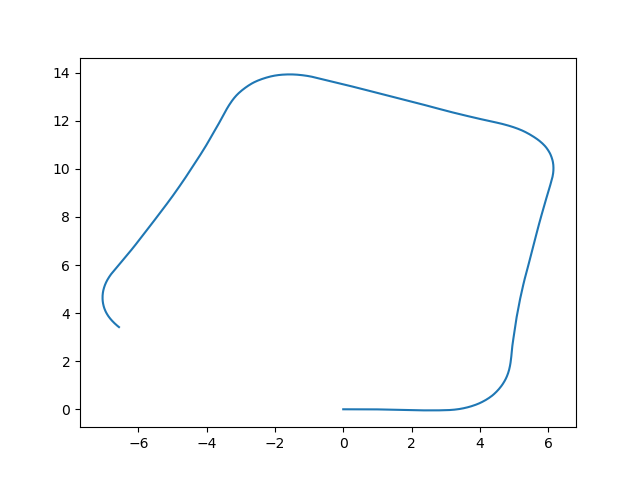

In [41]:
%matplotlib notebook
plt.plot(x,y)